In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from transformers import AutoTokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # or the specific model you used
tokenizer.save_pretrained("/content/")

('/content/tokenizer_config.json',
 '/content/special_tokens_map.json',
 '/content/vocab.txt',
 '/content/added_tokens.json',
 '/content/tokenizer.json')

In [ ]:
df = pd.read_csv("/content/labelled_news2.csv")
df.head()

,Unnamed: 0,title,link,author,date,paragraphs,sentiment
0,4,Tantalizers Plc unveils new leadership structu...,https://nairametrics.com/2024/11/15/tantalizer...,https://nairametrics.com/author/izuchukwu-okoye/,https://nairametrics.com/2024/11/15/tantalizer...,tantalizers plc announced appointment dutch na...,neutral
1,5,Northern Nigeria Flour Mills PLC declares inte...,https://nairametrics.com/2024/11/15/northern-n...,https://nairametrics.com/author/izuchukwu-okoye/,https://nairametrics.com/2024/11/15/northern-n...,northern nigeria flour mills plc announced int...,neutral
2,6,Access Holdings Plc acquires majority stake in...,https://nairametrics.com/2024/11/14/access-hol...,https://nairametrics.com/author/izuchukwu-okoye/,https://nairametrics.com/2024/11/14/access-hol...,access holdings plc announced banking subsidia...,positive
3,7,Consolidated Hallmark transitions to Limited L...,https://nairametrics.com/2024/11/13/consolidat...,https://nairametrics.com/author/izuchukwu-okoye/,https://nairametrics.com/2024/11/13/consolidat...,eddie efekoha consolidated hallmark officially...,neutral
4,8,UBA announces appointment of Henrietta Ugboh a...,https://nairametrics.com/2024/11/13/uba-announ...,https://nairametrics.com/author/nm-partners/,https://nairametrics.com/2024/11/13/uba-announ...,africa global bank united bank africa uba plc ...,neutral


In [ ]:
# Splitting data for Naive Bayes (75/25)
X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)
print(f"Naive Bayes Training Size: {len(X_train)}")
print(f"Naive Bayes Testing Size: {len(X_test)}")

Naive Bayes Training Size: 1546
Naive Bayes Testing Size: 516


In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['paragraphs'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['paragraphs'])

y_train = X_train['sentiment']
y_test = X_test['sentiment']

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1546, 19027)
(516, 19027)


In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
nb_predictions = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, nb_predictions))

Naive Bayes Accuracy: 0.6104651162790697
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.16      0.26       116
     neutral       0.65      0.93      0.77       255
    positive       0.48      0.40      0.44       145

    accuracy                           0.61       516
   macro avg       0.58      0.50      0.49       516
weighted avg       0.60      0.61      0.56       516



In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Check unique labels in y_train
unique_labels = np.unique(y_train)
print("Unique labels in y_train:", unique_labels)
# Compute class weights using unique labels in y_train
class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=y_train)

# Convert to dictionary
class_weight_dict = {cls: weight for cls, weight in zip(unique_labels, class_weights)}
print("Computed Class Weights:", class_weight_dict)
# Create sample weights for each training instance
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

nb_predictions2 = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy2 = accuracy_score(y_test, nb_predictions2)
print(f"Naive Bayes Accuracy: {accuracy2}")

print("Classification Report:")
print(classification_report(y_test, nb_predictions2))

Unique labels in y_train: ['negative' 'neutral' 'positive']
Computed Class Weights: {'negative': 1.435468895078923, 'neutral': 0.7137580794090489, 'positive': 1.1082437275985664}
Naive Bayes Accuracy: 0.624031007751938
Classification Report:
              precision    recall  f1-score   support

    negative       0.51      0.72      0.60       116
     neutral       0.82      0.62      0.70       255
    positive       0.50      0.57      0.53       145

    accuracy                           0.62       516
   macro avg       0.61      0.63      0.61       516
weighted avg       0.66      0.62      0.63       516



In [ ]:
# Define resampling strategy
resample = Pipeline([
    ('oversample', SMOTE(sampling_strategy={'negative': 700, 'positive': 800}, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy={'neutral': 700}, random_state=42))
])

# Apply resampling
X_resampled, y_resampled = resample.fit_resample(X_train_tfidf, y_train)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_resampled, y_resampled)

# Evaluate performance
y_pred = nb_classifier.predict(X_test_tfidf)
accuracy3 = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy3}")
print(classification_report(y_test, y_pred))


Naive Bayes Accuracy: 0.5813953488372093
              precision    recall  f1-score   support

    negative       0.52      0.53      0.52       116
     neutral       0.83      0.53      0.65       255
    positive       0.44      0.72      0.55       145

    accuracy                           0.58       516
   macro avg       0.60      0.59      0.57       516
weighted avg       0.65      0.58      0.59       516



In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test set
nb_predictions4 = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy4 = accuracy_score(y_test, nb_predictions4)
print(f"Naive Bayes Accuracy: {accuracy4}")

print("Classification Report:")
print(classification_report(y_test, nb_predictions4))

Naive Bayes Accuracy: 0.6511627906976745
Classification Report:
              precision    recall  f1-score   support

    negative       0.53      0.69      0.60       116
     neutral       0.84      0.67      0.74       255
    positive       0.53      0.59      0.56       145

    accuracy                           0.65       516
   macro avg       0.63      0.65      0.63       516
weighted avg       0.68      0.65      0.66       516



In [ ]:
class_labels = nb_classifier.classes_
print(class_labels)

['negative' 'neutral' 'positive']


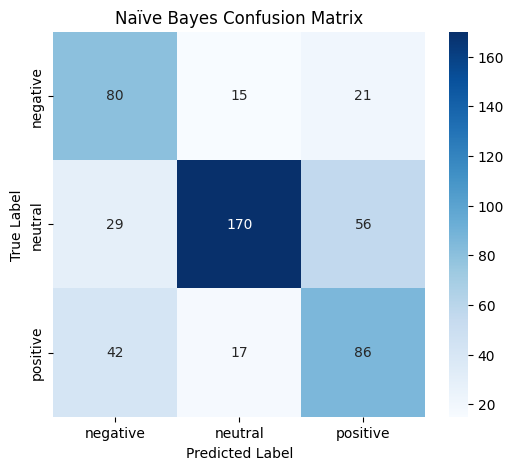

<Figure size 640x480 with 0 Axes>

In [ ]:
cm = confusion_matrix(y_test, nb_predictions4)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naïve Bayes Confusion Matrix")
plt.show()
plt.savefig("Naive Bayes Confusion Matrix")

In [ ]:
print(cm)

[[ 80  15  21]
 [ 29 170  56]
 [ 42  17  86]]


In [ ]:
from gensim.models import Word2Vec

# Example: Train Word2Vec on your dataset
tokenized_train = [article.split() for article in X_train["paragraphs"]]
tokenized_test = [article.split() for article in X_test["paragraphs"]]  # Tokenize articles
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)
w2v_models = Word2Vec(sentences=tokenized_test, vector_size=100, window=5, min_count=2, workers=4)

# Get word vectors for a sample word
#print(w2v_model.wv["market"])
nb_classifier5 = MultinomialNB()
nb_classifier5.fit(w2v_model, y_train)

# Make predictions on the test set
nb_predictions5 = nb_classifier5.predict(w2v_models)

# Evaluate the model
accuracy5 = accuracy_score(y_test, nb_predictions5)
print(f"Naive Bayes Accuracy: {accuracy5}")

print("Classification Report:")
print(classification_report(y_test, nb_predictions5))

NameError: name 'y_train' is not defined

In [ ]:
# Get word vectors for a sample word
#print(w2v_model.wv["market"])
nb_classifier5 = MultinomialNB()
nb_classifier5.fit(w2v_model, y_train)

# Make predictions on the test set
nb_predictions5 = nb_classifier5.predict(w2v_models)

# Evaluate the model
accuracy5 = accuracy_score(y_test, nb_predictions5)
print(f"Naive Bayes Accuracy: {accuracy5}")

print("Classification Report:")
print(classification_report(y_test, nb_predictions5))

ValueError: Expected 2D array, got scalar array instead:
array=Word2Vec<vocab=12822, vector_size=100, alpha=0.025>.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
import pickle

with open("naive-bayes-fin-news-predictor", "wb") as f:
    pickle.dump(nb_predictions4, f)

In [ ]:
# Splitting data for BERT/FinBERT (60/20/20)
bert_train, bert_temp = train_test_split(df, test_size=0.4, random_state=42)  # 40% for val/test
bert_val, bert_test = train_test_split(bert_temp, test_size=0.5, random_state=42)  # Split val/test evenly

print(f"BERT Training Size: {len(bert_train)}")
print(f"BERT Validation Size: {len(bert_val)}")
print(f"BERT Testing Size: {len(bert_test)}")

BERT Training Size: 1237
BERT Validation Size: 412
BERT Testing Size: 413


In [ ]:
# Choose a pre-trained model (you can try 'bert-base-uncased' or 'ProsusAI/finbert')
model_name = 'bert-base-uncased' # Or 'ProsusAI/finbert'

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(df, tokenizer, max_length=256):
    """
    Tokenizes the text data, adds special tokens, pads/truncates, and converts to tensors.
    """
    texts = df['paragraphs'].tolist()
    labels = df['sentiment'].tolist()

    # Tokenize the texts
    encoded_inputs = tokenizer(
        texts,
        padding='max_length',  # Pad to max_length
        truncation=True,       # Truncate to max_length
        max_length=max_length,
        return_tensors='tf'    # Return TensorFlow tensors
    )

    # Convert string labels to numerical labels
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}  # Define the mapping
    numerical_labels = [label_map[label] for label in labels] # Apply the mapping

    # Convert numerical labels to TensorFlow tensors
    labels_tensor = tf.convert_to_tensor(numerical_labels, dtype=tf.int32)

    return encoded_inputs['input_ids'], encoded_inputs['attention_mask'], labels_tensor


# Tokenize the training, validation, and testing sets
train_input_ids, train_attention_mask, train_labels = tokenize_data(bert_train, tokenizer)
val_input_ids, val_attention_mask, val_labels = tokenize_data(bert_val, tokenizer)
test_input_ids, test_attention_mask, test_labels = tokenize_data(bert_test, tokenizer)


print("Shape of training input ids:", train_input_ids.shape)
print("Shape of training attention mask:", train_attention_mask.shape)
print("Shape of training labels:", train_labels.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Shape of training input ids: (1237, 256)
Shape of training attention mask: (1237, 256)
Shape of training labels: (1237,)


In [ ]:
from transformers import TFAutoModelForSequenceClassification
import numpy as np
from tensorflow.keras.optimizers.legacy import Adam
from transformers import AdamWeightDecay

In [ ]:
# Load the pre-trained BERT/FinBERT model for sequence classification
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 classes: positive, neutral, negative


# Define optimizer, loss, and metrics
optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.01) # Adjust learning rate as needed
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # from_logits=True because the model returns logits
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(
    [train_input_ids, train_attention_mask],
    train_labels,
    validation_data=([val_input_ids, val_attention_mask], val_labels),
    epochs=5,  # Adjust the number of epochs
    batch_size=7 # Adjust the batch size
)

# Evaluate the model
evaluation = model.evaluate([test_input_ids, test_attention_mask], test_labels)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Make predictions
predictions = model.predict([test_input_ids, test_attention_mask])

# Convert logits to class labels
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Print classification report
label_names = ['positive', 'neutral', 'negative']  # Define label names
print(classification_report(test_labels, predicted_labels, target_names=label_names))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
177/177 [==============================] - 110s 505ms/step - loss: 1.0567 - accuracy: 0.4341 - val_loss: 1.0080 - val_accuracy: 0.5243
Epoch 2/5
177/177 [==============================] - 84s 475ms/step - loss: 0.9847 - accuracy: 0.5150 - val_loss: 0.9342 - val_accuracy: 0.5534
Epoch 3/5
177/177 [==============================] - 86s 486ms/step - loss: 0.9300 - accuracy: 0.5667 - val_loss: 0.8891 - val_accuracy: 0.5801
Epoch 4/5
177/177 [==============================] - 86s 486ms/step - loss: 0.8782 - accuracy: 0.6128 - val_loss: 0.8487 - val_accuracy: 0.6311
Epoch 5/5
13/13 [==============================] - 8s 571ms/step - loss: 0.7998 - accuracy: 0.6441
Test Loss: 0.7997674942016602
Test Accuracy: 0.6440678238868713
13/13 [==============================] - 17s 577ms/step
              precision    recall  f1-score   support

    positive       0.78      0.16      0.26        88
     neutral       0.72      0.89      0.79       203
    negative       0.50      0.59      0.